In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib pillow opencv-python lxml

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch torchvision pillow numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
voc_root = r"D:\VOCdevkit\VOC2012"  # Change to your actual VOC2012 path

In [5]:
pip install --upgrade pillow

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import glob

images_folder = r"D:\saliency\VOCdevkit\VOC2012\JPEGImages"  # <-- your actual path
print("Folder exists?", os.path.isdir(images_folder))

# Let's see what's inside the folder
print("Contents of JPEGImages folder:", os.listdir(images_folder))

# Now let's glob for .jpg
img_list = glob.glob(os.path.join(images_folder, '*.jpg'))
print("Found", len(img_list), "jpg files:")
for f in img_list[:5]:
    print("  ", f)


Folder exists? True
Contents of JPEGImages folder: ['2007_000027.jpg', '2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg', '2007_000042.jpg', '2007_000061.jpg', '2007_000063.jpg', '2007_000068.jpg', '2007_000121.jpg', '2007_000123.jpg', '2007_000129.jpg', '2007_000170.jpg', '2007_000175.jpg', '2007_000187.jpg', '2007_000241.jpg', '2007_000243.jpg', '2007_000250.jpg', '2007_000256.jpg', '2007_000272.jpg', '2007_000323.jpg', '2007_000332.jpg', '2007_000333.jpg', '2007_000346.jpg', '2007_000363.jpg', '2007_000364.jpg', '2007_000392.jpg', '2007_000423.jpg', '2007_000452.jpg', '2007_000464.jpg', '2007_000480.jpg', '2007_000491.jpg', '2007_000504.jpg', '2007_000515.jpg', '2007_000528.jpg', '2007_000529.jpg', '2007_000549.jpg', '2007_000559.jpg', '2007_000572.jpg', '2007_000584.jpg', '2007_000629.jpg', '2007_000636.jpg', '2007_000645.jpg', '2007_000648.jpg', '2007_000661.jpg', '2007_000663.jpg', '2007_000664.jpg', '2007_000676.jpg', '2007_000713.jpg', '2007_000720.jpg', '2007_000727.jpg'

In [7]:
import os
import glob

# CHANGE THIS to your actual VOC2012 path
voc_root = r"D:\saliency\VOCdevkit\VOC2012"

images_folder = os.path.join(voc_root, "JPEGImages")

print("Checking folder:", images_folder)
if not os.path.isdir(images_folder):
    print("[ERROR] JPEGImages folder not found. Check the path!")
    exit()

image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(images_folder, ext)))

print("Found", len(image_files), "images in", images_folder)
if image_files:
    print("First 5 images:")
    for img in image_files[:5]:
        print("  ", img)
else:
    print("[WARNING] No images found. Check file extensions or subfolders.")


Checking folder: D:\saliency\VOCdevkit\VOC2012\JPEGImages
Found 34250 images in D:\saliency\VOCdevkit\VOC2012\JPEGImages
First 5 images:
   D:\saliency\VOCdevkit\VOC2012\JPEGImages\2007_000027.jpg
   D:\saliency\VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg
   D:\saliency\VOCdevkit\VOC2012\JPEGImages\2007_000033.jpg
   D:\saliency\VOCdevkit\VOC2012\JPEGImages\2007_000039.jpg
   D:\saliency\VOCdevkit\VOC2012\JPEGImages\2007_000042.jpg


In [8]:
voc_root = r"D:\saliency\VOCdevkit\VOC2012"

In [9]:
import os
import glob
import xml.etree.ElementTree as ET

import torch
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision import models, transforms
from torchvision.ops import nms
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# ------------------------------------------------------------------------------
# 1. Helper Functions
# ------------------------------------------------------------------------------
def parse_voc_annotation(xml_file):
    """
    Reads a VOC-style XML annotation file and returns a list of dicts:
      Each dict has:
        'name' -> class name (e.g., "Camo", "person", etc.)
        'bbox' -> [xmin, ymin, xmax, ymax]
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall("object"):
        cls = obj.find("name").text.strip()
        bbox_xml = obj.find("bndbox")
        bbox = [
            float(bbox_xml.find("xmin").text),
            float(bbox_xml.find("ymin").text),
            float(bbox_xml.find("xmax").text),
            float(bbox_xml.find("ymax").text)
        ]
        objects.append({"name": cls, "bbox": bbox})
    return objects

def compute_iou(box1, box2):
    """
    Computes the Intersection over Union (IoU) of two bounding boxes.
    box format: [xmin, ymin, xmax, ymax]
    """
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    if (box1Area + box2Area - interArea) == 0:
        return 0.0

    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

def voc_ap(rec, prec):
    """
    Computes the Average Precision (AP) in a VOC-style manner:
    integrates over the precision-recall curve.
    """
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # Make precision monotonically decreasing
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])

    # Identify points where recall changes
    i_list = np.where(mrec[1:] != mrec[:-1])[0]
    ap = 0.0
    for i in i_list:
        ap += (mrec[i + 1] - mrec[i]) * mpre[i + 1]
    return ap

# ------------------------------------------------------------------------------
# 2. Paths and Model Setup
# ------------------------------------------------------------------------------
# IMPORTANT: Update this path to your actual VOC2012 location
voc_root = r"D:\saliency\VOCdevkit\VOC2012"

annotations_folder = os.path.join(voc_root, "Annotations")
images_folder = os.path.join(voc_root, "JPEGImages")

output_folder = os.path.join(voc_root, "output_detections")
os.makedirs(output_folder, exist_ok=True)

# Force CPU if you keep getting kernel crashes (optional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained Faster R-CNN
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = models.detection.fasterrcnn_resnet50_fpn(weights=weights)
model.eval()
model.to(device)  # Move model to GPU if available

# Transformation for input images
transform = transforms.Compose([
    # Optional resize to reduce memory usage:
    # transforms.Resize((800, 800)),
    transforms.ToTensor(),
])

# ------------------------------------------------------------------------------
# 3. Gather Image Files
# ------------------------------------------------------------------------------
# We'll read all JPG/JPEG/PNG images in the JPEGImages folder
image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(images_folder, ext)))

if not image_files:
    print("[ERROR] No image files found in the JPEGImages folder.")
    print("Check your path or file extensions.")
    exit()

# --------------------------
# Limit dataset to 30%
# --------------------------
import random
random.shuffle(image_files)
num_images = int(0.3 * len(image_files))
image_files = image_files[:num_images]
# --------------------------

print(f"Found {len(image_files)} images in {images_folder}.")
print("Starting inference...\n")

# ------------------------------------------------------------------------------
# 4. Detection & Evaluation Settings
# ------------------------------------------------------------------------------
CONFIDENCE_THRESHOLD = 0.2   # minimum score to keep a detection
NMS_THRESHOLD = 0.7          # Non-Max Suppression threshold
MIN_OBJECT_SIZE = 20         # ignore boxes smaller than this
IOU_THRESHOLD = 0.5          # IoU >= 0.5 => True Positive

# ------------------------------------------------------------------------------
# 5. Data Structures for Storing Results
# ------------------------------------------------------------------------------
# all_annotations: { class_name: { image_id: [ {bbox, detected}, ... ] } }
all_annotations = defaultdict(lambda: defaultdict(list))

# all_detections: { class_name: [ {image_id, confidence, bbox}, ... ] }
all_detections = defaultdict(list)

# For global metrics (Precision, Recall, F1, etc.)
global_TP = 0
global_FP = 0
global_FN = 0

# ------------------------------------------------------------------------------
# 6. Preload Annotations
# ------------------------------------------------------------------------------
# We read all XML files matching the images we have, so we don't skip any
for img_path in image_files:
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    xml_path = os.path.join(annotations_folder, f"{image_id}.xml")
    if os.path.exists(xml_path):
        objs = parse_voc_annotation(xml_path)
        for obj in objs:
            cls_name = obj["name"]
            all_annotations[cls_name][image_id].append({"bbox": obj["bbox"], "detected": False})

# ------------------------------------------------------------------------------
# 7. Run Inference & Collect Predictions
# ------------------------------------------------------------------------------
for i, img_file in enumerate(image_files):
    image_id = os.path.splitext(os.path.basename(img_file))[0]
    image = Image.open(img_file).convert("RGB")

    # Convert PIL to tensor
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Model Inference
    with torch.no_grad():
        predictions = model(img_tensor)[0]

    scores = predictions["scores"].cpu().numpy()
    boxes = predictions["boxes"].cpu().numpy()
    labels = predictions["labels"].cpu().numpy()  # COCO label IDs

    # Filter by confidence and box size
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []
    for j in range(len(scores)):
        score = scores[j]
        box = boxes[j]
        width = box[2] - box[0]
        height = box[3] - box[1]
        if score >= CONFIDENCE_THRESHOLD and width > MIN_OBJECT_SIZE and height > MIN_OBJECT_SIZE:
            filtered_boxes.append(box)
            filtered_scores.append(score)
            filtered_labels.append(labels[j])

    # Apply Non-Max Suppression (NMS)
    if filtered_boxes:
        keep_indices = nms(
            torch.tensor(filtered_boxes),
            torch.tensor(filtered_scores),
            NMS_THRESHOLD
        )
        filtered_boxes = [filtered_boxes[k] for k in keep_indices]
        filtered_scores = [filtered_scores[k] for k in keep_indices]
        filtered_labels = [filtered_labels[k] for k in keep_indices]

    print(f"[{i+1}/{len(image_files)}] {image_id}: {len(filtered_boxes)} final detections")

    # Store detections. 
    # If your dataset has only one class "Camo", you could replace "DetectedObject" with "Camo".
    # If multiple classes, map from COCO label IDs to your custom class names as needed.
    for box, score in zip(filtered_boxes, filtered_scores):
        class_name = "DetectedObject"  # or "Camo" if you only have one class
        all_detections[class_name].append({
            "image_id": image_id,
            "confidence": score,
            "bbox": box
        })

    # Optional: Visualization for the first 5 images
    if i < 5:
        draw_image = image.copy()
        draw = ImageDraw.Draw(draw_image)
        try:
            font = ImageFont.truetype("arial.ttf", 15)
        except IOError:
            font = ImageFont.load_default()

        for box, score in zip(filtered_boxes, filtered_scores):
            draw.rectangle(box, outline="red", width=2)
            text = f"{score:.2f}"
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_w = text_bbox[2] - text_bbox[0]
            text_h = text_bbox[3] - text_bbox[1]
            text_loc = (box[0], box[1] - text_h)
            # Draw text background
            draw.rectangle([text_loc, (box[0] + text_w, box[1])], fill="red")
            # Draw text
            draw.text(text_loc, text, fill="white", font=font)

        out_path = os.path.join(output_folder, f"{image_id}_det.jpg")
        draw_image.save(out_path)
        print(f"Saved visualization: {out_path}")

# ------------------------------------------------------------------------------
# 8. Compute Average Precision (AP) and Global Metrics
# ------------------------------------------------------------------------------
aps = {}

# Evaluate each class we have detections for
for cls_name, detections in all_detections.items():
    # Sort detections by confidence descending
    detections = sorted(detections, key=lambda x: x["confidence"], reverse=True)

    TP_array = np.zeros(len(detections))
    FP_array = np.zeros(len(detections))

    # Count total ground truth boxes for this class
    total_gt = 0
    if cls_name in all_annotations:
        for img_id in all_annotations[cls_name]:
            total_gt += len(all_annotations[cls_name][img_id])

    # Evaluate each detection
    for idx, det in enumerate(detections):
        image_id = det["image_id"]
        box_pred = det["bbox"]

        if cls_name in all_annotations and image_id in all_annotations[cls_name]:
            max_iou = 0
            assigned_gt = None
            for gt in all_annotations[cls_name][image_id]:
                iou = compute_iou(box_pred, gt["bbox"])
                if iou > max_iou:
                    max_iou = iou
                    assigned_gt = gt
            
            if max_iou >= IOU_THRESHOLD and assigned_gt is not None:
                if not assigned_gt["detected"]:
                    TP_array[idx] = 1
                    assigned_gt["detected"] = True
                else:
                    FP_array[idx] = 1
            else:
                FP_array[idx] = 1
        else:
            # No GT for this class in that image => false positive
            FP_array[idx] = 1

    cum_TP = np.cumsum(TP_array)
    cum_FP = np.cumsum(FP_array)
    rec = cum_TP / (total_gt + 1e-6)
    prec = cum_TP / (cum_TP + cum_FP + 1e-6)

    ap = voc_ap(rec, prec)
    aps[cls_name] = ap
    print(f"AP for class '{cls_name}': {ap:.4f}")

    TP_class = int(cum_TP[-1])
    FP_class = int(cum_FP[-1])
    FN_class = total_gt - TP_class

    global_TP += TP_class
    global_FP += FP_class
    global_FN += FN_class

# Mean Average Precision
mAP = np.mean(list(aps.values())) if aps else 0.0
print(f"\nMean Average Precision (mAP): {mAP:.4f}")

# ------------------------------------------------------------------------------
# 9. Compute Global Precision, Recall, F1, and Accuracy
# ------------------------------------------------------------------------------
precision_global = global_TP / float(global_TP + global_FP + 1e-6)
recall_global = global_TP / float(global_TP + global_FN + 1e-6)
f1_global = 2.0 * (precision_global * recall_global) / (precision_global + recall_global + 1e-6)
accuracy_global = global_TP / float(global_TP + global_FP + global_FN + 1e-6)

print("\n===== Global Metrics (across all classes & images) =====")
print(f"True Positives (TP): {global_TP}")
print(f"False Positives (FP): {global_FP}")
print(f"False Negatives (FN): {global_FN}")
print(f"Precision: {precision_global:.4f}")
print(f"Recall:    {recall_global:.4f}")
print(f"F1-score:  {f1_global:.4f}")
print(f"Accuracy:  {accuracy_global:.4f}")


Using device: cuda
Found 10275 images in D:\saliency\VOCdevkit\VOC2012\JPEGImages.
Starting inference...



C:\Users\FireFly\AppData\Local\Temp\ipykernel_17568\2958803059.py:207: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  torch.tensor(filtered_boxes),


[1/10275] 2008_006732: 10 final detections
Saved visualization: D:\saliency\VOCdevkit\VOC2012\output_detections\2008_006732_det.jpg
[2/10275] 2012_003030: 10 final detections
Saved visualization: D:\saliency\VOCdevkit\VOC2012\output_detections\2012_003030_det.jpg
[3/10275] 2008_006708: 2 final detections
Saved visualization: D:\saliency\VOCdevkit\VOC2012\output_detections\2008_006708_det.jpg
[4/10275] 2012_001108: 17 final detections
Saved visualization: D:\saliency\VOCdevkit\VOC2012\output_detections\2012_001108_det.jpg
[5/10275] 2008_003090: 2 final detections
Saved visualization: D:\saliency\VOCdevkit\VOC2012\output_detections\2008_003090_det.jpg
[6/10275] 2011_000420: 7 final detections
[7/10275] 2011_001591: 2 final detections
[8/10275] 2011_001107: 2 final detections
[9/10275] 2009_004945: 4 final detections
[10/10275] 2008_000217: 8 final detections
[11/10275] 2008_008170: 5 final detections
[12/10275] 2009_002031: 3 final detections
[13/10275] 2007_007414: 6 final detections
[1

In [1]:
import os
import glob
import xml.etree.ElementTree as ET

import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision import models, transforms
from torchvision.ops import nms
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import random
import matplotlib.cm as cm  # for heatmap colormap

# ------------------------------------------------------------------------------
# 1. Helper Functions
# ------------------------------------------------------------------------------
def parse_voc_annotation(xml_file):
    """
    Reads a VOC-style XML annotation file and returns a list of dicts:
      Each dict has:
        'name' -> class name (e.g., "person", "car", etc.)
        'bbox' -> [xmin, ymin, xmax, ymax]
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall("object"):
        cls = obj.find("name").text.strip()
        bbox_xml = obj.find("bndbox")
        bbox = [
            float(bbox_xml.find("xmin").text),
            float(bbox_xml.find("ymin").text),
            float(bbox_xml.find("xmax").text),
            float(bbox_xml.find("ymax").text)
        ]
        objects.append({"name": cls, "bbox": bbox})
    return objects

def compute_iou(box1, box2):
    """
    Computes the Intersection over Union (IoU) of two bounding boxes.
    box format: [xmin, ymin, xmax, ymax]
    """
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    if (box1Area + box2Area - interArea) == 0:
        return 0.0

    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

def voc_ap(rec, prec):
    """
    Computes the Average Precision (AP) in a VOC-style manner:
    integrates over the precision-recall curve.
    """
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # Make precision monotonically decreasing
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])

    # Identify points where recall changes
    i_list = np.where(mrec[1:] != mrec[:-1])[0]
    ap = 0.0
    for i in i_list:
        ap += (mrec[i + 1] - mrec[i]) * mpre[i + 1]
    return ap

def compute_saliency(input_tensor, model, coco_class_names, coco_to_voc):
    """
    Computes a simple gradient-based saliency map for the most confident VOC detection.
    The function expects input_tensor to require gradients.
    Returns a numpy saliency map (H x W) or None if no valid VOC detection is found.
    """
    # Run a forward pass with gradients enabled
    output = model(input_tensor)[0]
    top_idx = None
    top_score = -1
    # Loop over all detections to find the top one among VOC classes
    for i, (score, label) in enumerate(zip(output["scores"], output["labels"])):
        # Make sure label is within range
        if label >= len(coco_class_names):
            continue
        coco_class_name = coco_class_names[label]
        if coco_class_name in coco_to_voc:
            if score.item() > top_score:
                top_score = score.item()
                top_idx = i

    if top_idx is None:
        return None

    # Backpropagate the score of the chosen detection to the input image
    score = output["scores"][top_idx]
    model.zero_grad()
    score.backward(retain_graph=True)
    
    # input_tensor.grad now contains the gradients.
    # Take the maximum absolute gradient across the color channels
    saliency = input_tensor.grad.data.abs().squeeze()
    saliency, _ = torch.max(saliency, dim=0)
    saliency = saliency.cpu().numpy()
    return saliency

# ------------------------------------------------------------------------------
# 2. Paths and Model Setup
# ------------------------------------------------------------------------------
# IMPORTANT: Update this path to your actual VOC2012 location
voc_root = r"D:\saliency\VOCdevkit\VOC2012"

annotations_folder = os.path.join(voc_root, "Annotations")
images_folder = os.path.join(voc_root, "JPEGImages")

output_folder = os.path.join(voc_root, "output_detections_saliency")
os.makedirs(output_folder, exist_ok=True)

# Force CPU if you keep getting kernel crashes (optional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained Faster R-CNN
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = models.detection.fasterrcnn_resnet50_fpn(weights=weights)
model.eval()
model.to(device)  # Move model to GPU if available

# Transformation for input images
transform = transforms.Compose([
    # Optional resize to reduce memory usage:
    # transforms.Resize((800, 800)),
    transforms.ToTensor(),
])

# ------------------------------------------------------------------------------
# 3. Gather Image Files
# ------------------------------------------------------------------------------
# We'll read all JPG/JPEG/PNG images in the JPEGImages folder
image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(images_folder, ext)))

if not image_files:
    print("[ERROR] No image files found in the JPEGImages folder.")
    print("Check your path or file extensions.")
    exit()

# ------------------------------------------------------------------------------
# 3.1 Take only 30% of the dataset
# ------------------------------------------------------------------------------
random.shuffle(image_files)
num_images = int(0.3 * len(image_files))
image_files = image_files[:num_images]

print(f"Found {len(image_files)} images (30% of total).")
print("Starting inference...\n")

# ------------------------------------------------------------------------------
# 4. Detection & Evaluation Settings
# ------------------------------------------------------------------------------
CONFIDENCE_THRESHOLD = 0.2   # minimum score to keep a detection
NMS_THRESHOLD = 0.7          # Non-Max Suppression threshold
MIN_OBJECT_SIZE = 20         # ignore boxes smaller than this
IOU_THRESHOLD = 0.5          # IoU >= 0.5 => True Positive

# ------------------------------------------------------------------------------
# 5. Data Structures for Storing Results
# ------------------------------------------------------------------------------
# all_annotations: { class_name: { image_id: [ {bbox, detected}, ... ] } }
all_annotations = defaultdict(lambda: defaultdict(list))

# all_detections: { class_name: [ {image_id, confidence, bbox}, ... ] }
all_detections = defaultdict(list)

# For global metrics (Precision, Recall, F1, etc.)
global_TP = 0
global_FP = 0
global_FN = 0

# ------------------------------------------------------------------------------
# 6. COCO to VOC Class Mapping
# ------------------------------------------------------------------------------
# Official COCO labels for the model (index 0 is background)
COCO_INSTANCE_CATEGORY_NAMES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus",
    "train", "truck", "boat", "traffic light", "fire hydrant", "N/A", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "N/A", "backpack", "umbrella",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot",
    "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant",
    "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
    "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]

# Mapping from COCO class names to Pascal VOC 2012 class names
# (We only map the 20 classes that appear in VOC; all others are skipped)
COCO_TO_VOC = {
    "person": "person",
    "bicycle": "bicycle",
    "car": "car",
    "motorcycle": "motorbike",      # note "motorcycle" -> "motorbike"
    "airplane": "aeroplane",        # note "airplane" -> "aeroplane"
    "bus": "bus",
    "train": "train",
    "boat": "boat",
    "bird": "bird",
    "cat": "cat",
    "dog": "dog",
    "horse": "horse",
    "sheep": "sheep",
    "cow": "cow",
    "bottle": "bottle",
    "chair": "chair",
    "couch": "sofa",               # "couch" in COCO => "sofa" in VOC
    "potted plant": "pottedplant", # "potted plant" => "pottedplant"
    "dining table": "diningtable", # "dining table" => "diningtable"
    "tv": "tvmonitor"              # "tv" => "tvmonitor"
}

# ------------------------------------------------------------------------------
# 7. Preload Annotations
# ------------------------------------------------------------------------------
# We read all XML files matching the images we have, so we don't skip any
for img_path in image_files:
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    xml_path = os.path.join(annotations_folder, f"{image_id}.xml")
    if os.path.exists(xml_path):
        objs = parse_voc_annotation(xml_path)
        for obj in objs:
            cls_name = obj["name"]
            all_annotations[cls_name][image_id].append({"bbox": obj["bbox"], "detected": False})

# ------------------------------------------------------------------------------
# 8. Run Inference & Collect Predictions
# ------------------------------------------------------------------------------
for i, img_file in enumerate(image_files):
    image_id = os.path.splitext(os.path.basename(img_file))[0]
    image = Image.open(img_file).convert("RGB")

    # Convert PIL to tensor
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Model Inference (no gradient computation here)
    with torch.no_grad():
        predictions = model(img_tensor)[0]

    scores = predictions["scores"].cpu().numpy()
    boxes = predictions["boxes"].cpu().numpy()
    labels = predictions["labels"].cpu().numpy()  # COCO label IDs

    # Filter by confidence and box size
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []
    for j in range(len(scores)):
        score = scores[j]
        box = boxes[j]
        width = box[2] - box[0]
        height = box[3] - box[1]
        if score >= CONFIDENCE_THRESHOLD and width > MIN_OBJECT_SIZE and height > MIN_OBJECT_SIZE:
            filtered_boxes.append(box)
            filtered_scores.append(score)
            filtered_labels.append(labels[j])

    # Apply Non-Max Suppression (NMS)
    if filtered_boxes:
        keep_indices = nms(
            torch.tensor(filtered_boxes),
            torch.tensor(filtered_scores),
            NMS_THRESHOLD
        )
        filtered_boxes = [filtered_boxes[k] for k in keep_indices]
        filtered_scores = [filtered_scores[k] for k in keep_indices]
        filtered_labels = [filtered_labels[k] for k in keep_indices]

    print(f"[{i+1}/{len(image_files)}] {image_id}: {len(filtered_boxes)} final detections")

    # Map each detection's COCO label to its VOC counterpart (if it exists)
    for box, score, label_id in zip(filtered_boxes, filtered_scores, filtered_labels):
        # Get the COCO class name
        if label_id < len(COCO_INSTANCE_CATEGORY_NAMES):
            coco_class_name = COCO_INSTANCE_CATEGORY_NAMES[label_id]
        else:
            continue

        # Convert COCO name to VOC name (skip if not in VOC set)
        if coco_class_name in COCO_TO_VOC:
            class_name = COCO_TO_VOC[coco_class_name]
        else:
            continue

        # Store the detection
        all_detections[class_name].append({
            "image_id": image_id,
            "confidence": score,
            "bbox": box
        })

    # ------------------------------------------------------------------------------
    # Optional: Visualization (including Saliency) for the first 5 images
    # ------------------------------------------------------------------------------
    if i < 5:
        # Copy original image for drawing boxes
        draw_image = image.copy()
        draw = ImageDraw.Draw(draw_image)
        try:
            font = ImageFont.truetype("arial.ttf", 15)
        except IOError:
            font = ImageFont.load_default()

        for box, score, label_id in zip(filtered_boxes, filtered_scores, filtered_labels):
            if label_id < len(COCO_INSTANCE_CATEGORY_NAMES):
                coco_class_name = COCO_INSTANCE_CATEGORY_NAMES[label_id]
                if coco_class_name in COCO_TO_VOC:
                    voc_class_name = COCO_TO_VOC[coco_class_name]
                else:
                    continue
            else:
                continue

            draw.rectangle(box, outline="red", width=2)
            text = f"{voc_class_name}: {score:.2f}"
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_w = text_bbox[2] - text_bbox[0]
            text_h = text_bbox[3] - text_bbox[1]
            text_loc = (box[0], box[1] - text_h)
            # Draw text background
            draw.rectangle([text_loc, (box[0] + text_w, box[1])], fill="red")
            # Draw text
            draw.text(text_loc, text, fill="white", font=font)

        # Save the detection visualization
        out_path = os.path.join(output_folder, f"{image_id}_det.jpg")
        draw_image.save(out_path)
        print(f"Saved detection visualization: {out_path}")

        # -------------------------------
        # Compute and visualize saliency
        # -------------------------------
        # Create a new input tensor with gradients enabled for saliency computation.
        saliency_tensor = transform(image).unsqueeze(0).to(device)
        saliency_tensor.requires_grad = True

        saliency_map = compute_saliency(saliency_tensor, model, COCO_INSTANCE_CATEGORY_NAMES, COCO_TO_VOC)
        if saliency_map is not None:
            # Normalize saliency map to [0, 1]
            saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-8)
            # Convert saliency map to heatmap (using a colormap, e.g., jet)
            saliency_heatmap = cm.jet(saliency_map)[:, :, :3]  # drop alpha channel
            saliency_heatmap = (saliency_heatmap * 255).astype(np.uint8)
            saliency_image = Image.fromarray(saliency_heatmap).resize(image.size)

            # Blend saliency heatmap with the original image
            blended = Image.blend(image, saliency_image, alpha=0.5)
            saliency_out_path = os.path.join(output_folder, f"{image_id}_saliency.jpg")
            blended.save(saliency_out_path)
            print(f"Saved saliency visualization: {saliency_out_path}")
        else:
            print(f"No valid VOC detection for saliency in image {image_id}.")

# ------------------------------------------------------------------------------
# 9. Compute Average Precision (AP) and Global Metrics
# ------------------------------------------------------------------------------
aps = {}

# Evaluate each class we have detections for
for cls_name, detections in all_detections.items():
    # Sort detections by confidence descending
    detections = sorted(detections, key=lambda x: x["confidence"], reverse=True)

    TP_array = np.zeros(len(detections))
    FP_array = np.zeros(len(detections))

    # Count total ground truth boxes for this class
    total_gt = 0
    if cls_name in all_annotations:
        for img_id in all_annotations[cls_name]:
            total_gt += len(all_annotations[cls_name][img_id])

    # Evaluate each detection
    for idx, det in enumerate(detections):
        image_id = det["image_id"]
        box_pred = det["bbox"]

        if cls_name in all_annotations and image_id in all_annotations[cls_name]:
            max_iou = 0
            assigned_gt = None
            for gt in all_annotations[cls_name][image_id]:
                iou = compute_iou(box_pred, gt["bbox"])
                if iou > max_iou:
                    max_iou = iou
                    assigned_gt = gt
            
            if max_iou >= IOU_THRESHOLD and assigned_gt is not None:
                if not assigned_gt["detected"]:
                    TP_array[idx] = 1
                    assigned_gt["detected"] = True
                else:
                    FP_array[idx] = 1
            else:
                FP_array[idx] = 1
        else:
            FP_array[idx] = 1

    cum_TP = np.cumsum(TP_array)
    cum_FP = np.cumsum(FP_array)
    rec = cum_TP / (total_gt + 1e-6)
    prec = cum_TP / (cum_TP + cum_FP + 1e-6)

    ap = voc_ap(rec, prec)
    aps[cls_name] = ap
    print(f"AP for class '{cls_name}': {ap:.4f}")

    TP_class = int(cum_TP[-1])
    FP_class = int(cum_FP[-1])
    FN_class = total_gt - TP_class

    global_TP += TP_class
    global_FP += FP_class
    global_FN += FN_class

# Mean Average Precision
mAP = np.mean(list(aps.values())) if aps else 0.0
print(f"\nMean Average Precision (mAP): {mAP:.4f}")

# ------------------------------------------------------------------------------
# 10. Compute Global Precision, Recall, F1, and Accuracy
# ------------------------------------------------------------------------------
precision_global = global_TP / float(global_TP + global_FP + 1e-6)
recall_global = global_TP / float(global_TP + global_FN + 1e-6)
f1_global = 2.0 * (precision_global * recall_global) / (precision_global + recall_global + 1e-6)
accuracy_global = global_TP / float(global_TP + global_FP + global_FN + 1e-6)

print("\n===== Global Metrics (across all classes & images) =====")
print(f"True Positives (TP): {global_TP}")
print(f"False Positives (FP): {global_FP}")
print(f"False Negatives (FN): {global_FN}")
print(f"Precision: {precision_global:.4f}")
print(f"Recall:    {recall_global:.4f}")
print(f"F1-score:  {f1_global:.4f}")
print(f"Accuracy:  {accuracy_global:.4f}")


Using device: cuda
Found 10275 images (30% of total).
Starting inference...



C:\Users\FireFly\AppData\Local\Temp\ipykernel_10216\372103112.py:287: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  torch.tensor(filtered_boxes),


[1/10275] 2011_001793: 8 final detections
Saved detection visualization: D:\saliency\VOCdevkit\VOC2012\output_detections_saliency\2011_001793_det.jpg
Saved saliency visualization: D:\saliency\VOCdevkit\VOC2012\output_detections_saliency\2011_001793_saliency.jpg
[2/10275] 2009_000251: 4 final detections
Saved detection visualization: D:\saliency\VOCdevkit\VOC2012\output_detections_saliency\2009_000251_det.jpg
Saved saliency visualization: D:\saliency\VOCdevkit\VOC2012\output_detections_saliency\2009_000251_saliency.jpg
[3/10275] 2009_000131: 6 final detections
Saved detection visualization: D:\saliency\VOCdevkit\VOC2012\output_detections_saliency\2009_000131_det.jpg
Saved saliency visualization: D:\saliency\VOCdevkit\VOC2012\output_detections_saliency\2009_000131_saliency.jpg
[4/10275] 2009_003333: 3 final detections
Saved detection visualization: D:\saliency\VOCdevkit\VOC2012\output_detections_saliency\2009_003333_det.jpg
Saved saliency visualization: D:\saliency\VOCdevkit\VOC2012\outp

Epoch 1/5: 100%|███████████████████████████████████████████████████████████| 94/94 [25:59<00:00, 16.59s/it, loss=0.403]


Epoch 1 - Avg Loss: 0.8736


Epoch 2/5: 100%|███████████████████████████████████████████████████████████| 94/94 [26:59<00:00, 17.23s/it, loss=0.285]


Epoch 2 - Avg Loss: 0.6315


Epoch 3/5: 100%|███████████████████████████████████████████████████████████| 94/94 [26:36<00:00, 16.98s/it, loss=0.439]


Epoch 3 - Avg Loss: 0.5405


Epoch 4/5: 100%|███████████████████████████████████████████████████████████| 94/94 [27:03<00:00, 17.27s/it, loss=0.638]


Epoch 4 - Avg Loss: 0.4724


Epoch 5/5: 100%|████████████████████████████████████████████████████████████| 94/94 [25:33<00:00, 16.31s/it, loss=0.37]


Epoch 5 - Avg Loss: 0.4589
Training complete!


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 377/377 [00:55<00:00,  6.81it/s]


Validation Accuracy: 64.38% (752/1168)


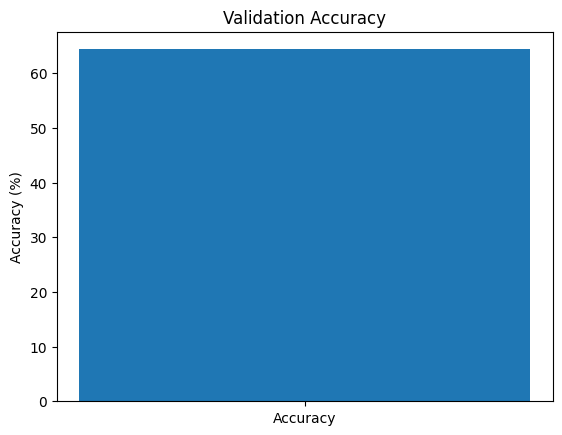

In [2]:
import torch
import torchvision
import torchvision.transforms.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Subset
import random
import math
from PIL import Image, ImageOps
from torchvision.datasets import VOCDetection
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Saliency Map Function
def compute_saliency(image):
    grayscale = image.mean(dim=0, keepdim=True)
    saliency_map = grayscale / grayscale.max()
    return saliency_map.repeat(3, 1, 1)  # Ensure it's 3-channel

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        saliency = compute_saliency(image)
        image = image * saliency
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if random.random() < self.p:
            image = ImageOps.mirror(image)
            ann = target['annotation']
            width = image.size[0]
            def flip_box(bbox):
                xmin = float(bbox['xmin'])
                xmax = float(bbox['xmax'])
                bbox['xmin'] = str(width - xmax)
                bbox['xmax'] = str(width - xmin)
                return bbox
            
            if 'object' in ann:
                objects = ann['object']
                if isinstance(objects, list):
                    for obj in objects:
                        obj['bndbox'] = flip_box(obj['bndbox'])
                else:
                    ann['object']['bndbox'] = flip_box(ann['object']['bndbox'])
            target['annotation'] = ann
        return image, target

def get_transform(train):
    transforms = []
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    transforms.append(ToTensor())
    return Compose(transforms)

VOC_CLASSES = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

def voc_class_to_int(class_name):
    return VOC_CLASSES.index(class_name)

def parse_voc_annotation(target):
    ann = target['annotation']
    objects = ann.get('object', [])
    if not isinstance(objects, list):
        objects = [objects]
    
    boxes = []
    labels = []
    for obj in objects:
        bbox = obj['bndbox']
        box = [
            float(bbox['xmin']),
            float(bbox['ymin']),
            float(bbox['xmax']),
            float(bbox['ymax'])
        ]
        boxes.append(box)
        labels.append(voc_class_to_int(obj['name']))
    
    return {
        'boxes': torch.as_tensor(boxes, dtype=torch.float32),
        'labels': torch.as_tensor(labels, dtype=torch.int64)
    }

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# Load datasets
full_train_dataset = VOCDetection(
    root='VOCdevkit', year='2007', image_set='train',
    download=True, transforms=get_transform(train=True)
)
full_val_dataset = VOCDetection(
    root='VOCdevkit', year='2007', image_set='val',
    download=False, transforms=get_transform(train=False)
)

# Use 15% of datasets
train_size = math.ceil(0.15 * len(full_train_dataset))
val_size = math.ceil(0.15 * len(full_val_dataset))

train_dataset = Subset(full_train_dataset, random.sample(range(len(full_train_dataset)), train_size))
val_dataset = Subset(full_val_dataset, random.sample(range(len(full_val_dataset)), val_size))

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(VOC_CLASSES)
model = get_model(num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets_converted = [parse_voc_annotation(t) for t in targets]
        targets_converted = [{k: v.to(device) for k, v in target.items()} for target in targets_converted]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets_converted)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())
    
    lr_scheduler.step()
    print(f"Epoch {epoch+1} - Avg Loss: {epoch_loss / len(train_loader):.4f}")

print("Training complete!")

# Accuracy calculation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for output, target in zip(outputs, targets):
            pred_boxes = output['boxes']
            true_boxes = parse_voc_annotation(target)['boxes'].to(device)
            
            for t_box in true_boxes:
                if any(torch.allclose(t_box, p_box, atol=20.0) for p_box in pred_boxes):
                    correct += 1
            total += len(true_boxes)

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")

# Optional: Accuracy plot
plt.bar(['Accuracy'], [accuracy])
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.show()


In [1]:
import torch
import torchvision
import torchvision.transforms.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Subset
import random
import math
from PIL import Image, ImageOps
from torchvision.datasets import VOCDetection
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as nnf
import matplotlib.patches as patches

# Saliency using Sobel Filters
def compute_saliency(image, alpha=0.5):
    grayscale = image.mean(dim=0, keepdim=True)
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    edge_x = nnf.conv2d(grayscale.unsqueeze(0), sobel_x, padding=1)
    edge_y = nnf.conv2d(grayscale.unsqueeze(0), sobel_y, padding=1)
    
    saliency_map = torch.sqrt(edge_x ** 2 + edge_y ** 2).squeeze(0)
    saliency_map = saliency_map / saliency_map.max()
    
    enhanced_saliency = (1 - alpha) + alpha * saliency_map
    return enhanced_saliency.repeat(3, 1, 1)

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        saliency = compute_saliency(image)
        image = image * saliency
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if random.random() < self.p:
            image = ImageOps.mirror(image)
        return image, target

def get_transform(train):
    transforms = []
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    transforms.append(ToTensor())
    return Compose(transforms)

VOC_CLASSES = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

def voc_class_to_int(class_name):
    return VOC_CLASSES.index(class_name)

def parse_voc_annotation(target):
    ann = target['annotation']
    objects = ann.get('object', [])
    if not isinstance(objects, list):
        objects = [objects]
    
    boxes = []
    labels = []
    for obj in objects:
        bbox = obj['bndbox']
        box = [
            float(bbox['xmin']),
            float(bbox['ymin']),
            float(bbox['xmax']),
            float(bbox['ymax'])
        ]
        boxes.append(box)
        labels.append(voc_class_to_int(obj['name']))
    
    return {
        'boxes': torch.as_tensor(boxes, dtype=torch.float32),
        'labels': torch.as_tensor(labels, dtype=torch.int64)
    }

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# Dataset
train_dataset = VOCDetection('VOCdevkit', year='2007', image_set='train', download=True, transforms=get_transform(train=True))
val_dataset = VOCDetection('VOCdevkit', year='2007', image_set='val', download=False, transforms=get_transform(train=False))

train_size = math.ceil(0.15 * len(train_dataset))
val_size = math.ceil(0.15 * len(val_dataset))

train_dataset = Subset(train_dataset, random.sample(range(len(train_dataset)), train_size))
val_dataset = Subset(val_dataset, random.sample(range(len(val_dataset)), val_size))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(VOC_CLASSES)
model = get_model(num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [parse_voc_annotation(t) for t in targets]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())
    
    lr_scheduler.step()
    print(f"Epoch {epoch+1} - Avg Loss: {epoch_loss / len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for output, target in zip(outputs, targets):
            pred_boxes = output['boxes']
            true_boxes = parse_voc_annotation(target)['boxes'].to(device)
            
            for t_box in true_boxes:
                if any(torch.allclose(t_box, p_box, atol=20.0) for p_box in pred_boxes):
                    correct += 1
            total += len(true_boxes)

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")

# Visualization with Progress Bar
def show_image_with_boxes(image, boxes, title):
    image = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.set_title(title)
    plt.axis('off')
    plt.show()

with torch.no_grad():
    for idx, (images, targets) in enumerate(tqdm(val_loader, desc="Visualizing")):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for img, output in zip(images, outputs):
            saliency = compute_saliency(img)
            show_image_with_boxes(img, output['boxes'], "Original with Boxes")
            show_image_with_boxes(img * saliency, output['boxes'], "Saliency-Enhanced with Boxes")
        
        if idx >= 2:
            break


Epoch 1/5: 100%|███████████████████████████████████████████████████████████| 94/94 [24:45<00:00, 15.80s/it, loss=0.475]


Epoch 1 - Avg Loss: 0.8952


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████| 94/94 [27:43<00:00, 17.70s/it, loss=0.4]


Epoch 2 - Avg Loss: 0.6882


Epoch 3/5: 100%|███████████████████████████████████████████████████████████| 94/94 [26:34<00:00, 16.96s/it, loss=0.953]


Epoch 3 - Avg Loss: 0.6592


Epoch 4/5: 100%|███████████████████████████████████████████████████████████| 94/94 [28:27<00:00, 18.17s/it, loss=0.996]


Epoch 4 - Avg Loss: 0.6216


Epoch 5/5: 100%|███████████████████████████████████████████████████████████| 94/94 [26:53<00:00, 17.17s/it, loss=0.654]


Epoch 5 - Avg Loss: 0.6212
Training complete!


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 377/377 [00:53<00:00,  6.99it/s]


Validation Accuracy: 57.60% (648/1125)


Visualizing:   0%|                                                                             | 0/377 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 94/94 [19:53<00:00, 12.70s/it, loss=0.356]


Epoch 1 - Avg Loss: 0.7494


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 94/94 [21:17<00:00, 13.59s/it, loss=0.776]


Epoch 2 - Avg Loss: 0.5256


Epoch 3/10: 100%|███████████████████████████████████████████████████████████| 94/94 [21:26<00:00, 13.68s/it, loss=0.38]


Epoch 3 - Avg Loss: 0.4254


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 94/94 [21:49<00:00, 13.93s/it, loss=0.375]


Epoch 4 - Avg Loss: 0.3601


Epoch 5/10: 100%|█████████████████████████████████████████████████████████| 94/94 [21:56<00:00, 14.01s/it, loss=0.0944]


Epoch 5 - Avg Loss: 0.2919


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 94/94 [22:33<00:00, 14.40s/it, loss=0.284]


Epoch 6 - Avg Loss: 0.2493


Epoch 7/10: 100%|███████████████████████████████████████████████████████████| 94/94 [22:20<00:00, 14.26s/it, loss=0.24]


Epoch 7 - Avg Loss: 0.2355


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 94/94 [22:06<00:00, 14.11s/it, loss=0.107]


Epoch 8 - Avg Loss: 0.2139


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 94/94 [21:50<00:00, 13.94s/it, loss=0.282]


Epoch 9 - Avg Loss: 0.1879


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 94/94 [22:10<00:00, 14.15s/it, loss=0.123]


Epoch 10 - Avg Loss: 0.1735
Training complete!


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 377/377 [02:15<00:00,  2.78it/s]


Validation Accuracy: 57.63% (725/1258)


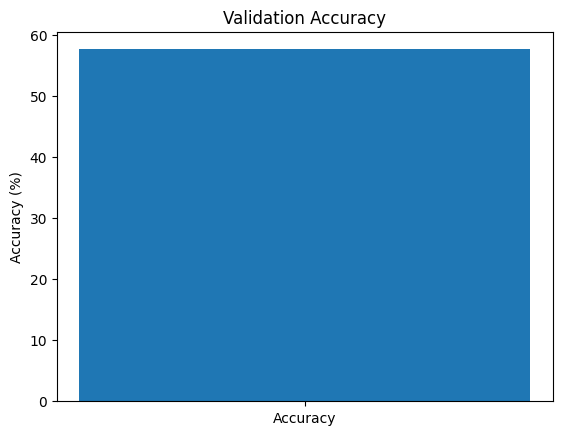

C:\Users\FireFly\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


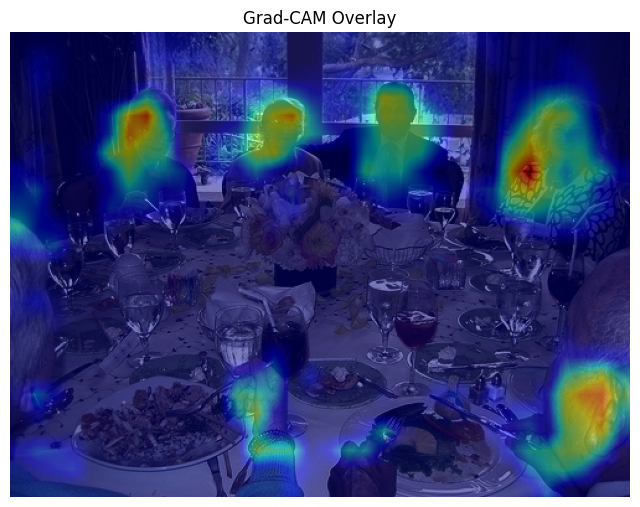

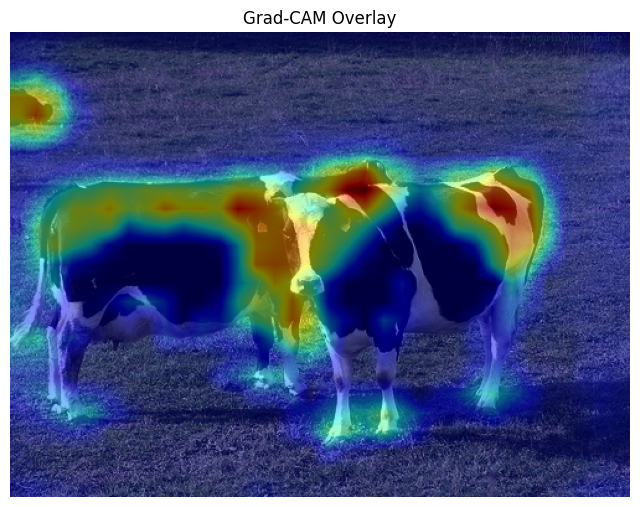

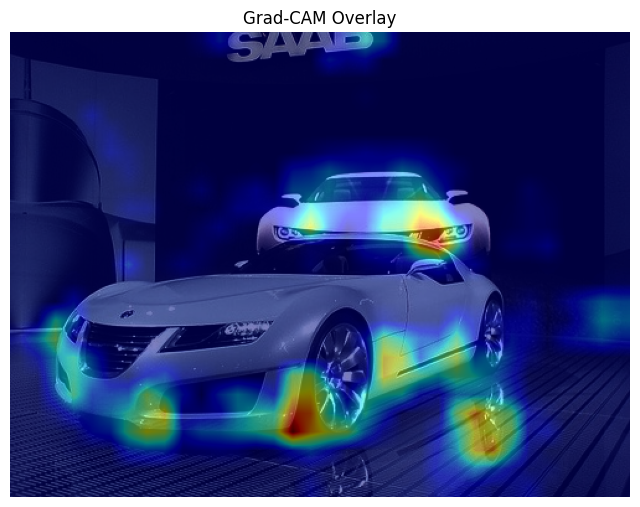

In [1]:
import torch
import torchvision
import torchvision.transforms.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Subset
import random
import math
from PIL import Image, ImageOps, ImageEnhance
from torchvision.datasets import VOCDetection
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Grad-CAM Module ----------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        handle_backward = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.append(handle_forward)
        self.hook_handles.append(handle_backward)
    
    def __del__(self):
        for handle in self.hook_handles:
            handle.remove()
    
    def generate(self, input_tensor, index=None):
        # Forward pass
        output = self.model(input_tensor)
        # For simplicity, if there are any detections take the one with highest score
        if len(output[0]['scores']) > 0:
            if index is None:
                index = output[0]['scores'].argmax().item()
            score = output[0]['scores'][index]
            self.model.zero_grad()
            score.backward(retain_graph=True)
            
            # Compute the weights: global-average pooling over gradients
            weights = self.gradients.mean(dim=[2, 3], keepdim=True)
            gradcam_map = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
            gradcam_map = torch.nn.functional.interpolate(gradcam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
            gradcam_map = gradcam_map.squeeze().cpu().numpy()
            gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min() + 1e-8)
            return gradcam_map, output
        else:
            return None, output

# ---------------- End Grad-CAM Module ----------------

# Original simple saliency function remains available
def compute_saliency(image):
    grayscale = image.mean(dim=0, keepdim=True)
    saliency_map = grayscale / (grayscale.max() + 1e-8)
    return saliency_map.repeat(3, 1, 1)

# Compose helper to chain transforms
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# Additional data augmentation: color jitter
class ColorJitterTransform(object):
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
        self.jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )
    
    def __call__(self, image, target):
        image = self.jitter(image)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        # Multiply by a simple saliency map; you could later replace this with a Grad-CAM–based map
        saliency = compute_saliency(image)
        image = image * saliency
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if random.random() < self.p:
            image = ImageOps.mirror(image)
            ann = target['annotation']
            width = image.size[0]
            def flip_box(bbox):
                xmin = float(bbox['xmin'])
                xmax = float(bbox['xmax'])
                bbox['xmin'] = str(width - xmax)
                bbox['xmax'] = str(width - xmin)
                return bbox
            
            if 'object' in ann:
                objects = ann['object']
                if isinstance(objects, list):
                    for obj in objects:
                        obj['bndbox'] = flip_box(obj['bndbox'])
                else:
                    ann['object']['bndbox'] = flip_box(ann['object']['bndbox'])
            target['annotation'] = ann
        return image, target

def get_transform(train):
    transforms = []
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(ColorJitterTransform())  # added augmentation
    transforms.append(ToTensor())
    return Compose(transforms)

VOC_CLASSES = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

def voc_class_to_int(class_name):
    return VOC_CLASSES.index(class_name)

def parse_voc_annotation(target):
    ann = target['annotation']
    objects = ann.get('object', [])
    if not isinstance(objects, list):
        objects = [objects]
    
    boxes = []
    labels = []
    for obj in objects:
        bbox = obj['bndbox']
        box = [
            float(bbox['xmin']),
            float(bbox['ymin']),
            float(bbox['xmax']),
            float(bbox['ymax'])
        ]
        boxes.append(box)
        labels.append(voc_class_to_int(obj['name']))
    
    return {
        'boxes': torch.as_tensor(boxes, dtype=torch.float32),
        'labels': torch.as_tensor(labels, dtype=torch.int64)
    }

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# ---------------- Load Data ----------------
full_train_dataset = VOCDetection(
    root='VOCdevkit', year='2007', image_set='train',
    download=True, transforms=get_transform(train=True)
)
full_val_dataset = VOCDetection(
    root='VOCdevkit', year='2007', image_set='val',
    download=False, transforms=get_transform(train=False)
)

# Use 15% of datasets (note: using a small subset may limit accuracy)
train_size = math.ceil(0.15 * len(full_train_dataset))
val_size = math.ceil(0.15 * len(full_val_dataset))

train_dataset = Subset(full_train_dataset, random.sample(range(len(full_train_dataset)), train_size))
val_dataset = Subset(full_val_dataset, random.sample(range(len(full_val_dataset)), val_size))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# ---------------- Model, Optimizer, Scheduler ----------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(VOC_CLASSES)
model = get_model(num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]
# Increase the learning rate slightly and adjust momentum if needed
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0001)
# Adjust scheduler to decay LR more aggressively
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

# ---------------- Training Loop ----------------
# Increase the number of epochs for better convergence
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets_converted = [parse_voc_annotation(t) for t in targets]
        targets_converted = [{k: v.to(device) for k, v in target.items()} for target in targets_converted]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets_converted)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())
    
    lr_scheduler.step()
    print(f"Epoch {epoch+1} - Avg Loss: {epoch_loss / len(train_loader):.4f}")

print("Training complete!")

# ---------------- Evaluation ----------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for output, target in zip(outputs, targets):
            pred_boxes = output['boxes']
            true_boxes = parse_voc_annotation(target)['boxes'].to(device)
            
            for t_box in true_boxes:
                if any(torch.allclose(t_box, p_box, atol=20.0) for p_box in pred_boxes):
                    correct += 1
            total += len(true_boxes)

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")

plt.bar(['Accuracy'], [accuracy])
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.show()

# ---------------- Grad-CAM Visualization ----------------
# Here we use Grad-CAM on the backbone’s last conv layer (ResNet50's layer4)
target_layer = model.backbone.body.layer4
gradcam = GradCAM(model, target_layer)

# Visualize Grad-CAM for a few samples from the validation set
visualize_samples = 3
for i in range(visualize_samples):
    image, target = val_dataset[i]
    # image is already transformed (tensor); add batch dimension and move to device
    img_tensor = image.unsqueeze(0).to(device)
    gradcam_map, output = gradcam.generate(img_tensor)
    if gradcam_map is not None:
        # Convert tensor image back to numpy for display
        orig_img = image.permute(1, 2, 0).cpu().numpy()
        plt.figure(figsize=(8,8))
        plt.imshow(orig_img)
        plt.imshow(gradcam_map, cmap='jet', alpha=0.5)
        plt.title("Grad-CAM Overlay")
        plt.axis('off')
        plt.show()


In [6]:
import torch
import torchvision
import torchvision.transforms.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Subset
import random
import math
from PIL import Image, ImageOps
from torchvision.datasets import VOCDetection
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Dataset Path ----------------
DATASET_PATH = "D:/saliency/VOCdevkit"

# ---------------- Grad-CAM Module ----------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        handle_backward = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.append(handle_forward)
        self.hook_handles.append(handle_backward)
    
    def __del__(self):
        for handle in self.hook_handles:
            handle.remove()
    
    def generate(self, input_tensor):
        output = self.model(input_tensor)
        if len(output[0]['scores']) > 0:
            index = output[0]['scores'].argmax().item()
            score = output[0]['scores'][index]
            self.model.zero_grad()
            score.backward(retain_graph=True)
            weights = self.gradients.mean(dim=[2, 3], keepdim=True)
            gradcam_map = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
            gradcam_map = torch.nn.functional.interpolate(gradcam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
            return gradcam_map.squeeze().cpu().numpy(), output
        return None, output

# ---------------- Transformations ----------------
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ColorJitterTransform:
    def __call__(self, image, target):
        image = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)(image)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip:
    def __call__(self, image, target):
        if random.random() < 0.5:
            image = ImageOps.mirror(image)
        return image, target

def get_transform(train):
    transforms = [RandomHorizontalFlip(), ColorJitterTransform(), ToTensor()] if train else [ToTensor()]
    return Compose(transforms)

# ---------------- Dataset Preparation ----------------
train_dataset = VOCDetection(root=DATASET_PATH, year='2012', image_set='train', download=False, transforms=get_transform(train=True))
val_dataset = VOCDetection(root=DATASET_PATH, year='2012', image_set='val', download=False, transforms=get_transform(train=False))

train_size = math.ceil(0.15 * len(train_dataset))
val_size = math.ceil(0.15 * len(val_dataset))

train_dataset = Subset(train_dataset, random.sample(range(len(train_dataset)), train_size))
val_dataset = Subset(val_dataset, random.sample(range(len(val_dataset)), val_size))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# ---------------- Model Definition ----------------
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 21
model = get_model(num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

# ---------------- Training Loop ----------------
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())
    
    lr_scheduler.step()
    print(f"Epoch {epoch+1} - Avg Loss: {epoch_loss / len(train_loader):.4f}")

print("Training complete!")

# ---------------- Evaluation ----------------
model.eval()
correct = 0
with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        correct += sum(len(o['boxes']) for o in outputs)

accuracy = 100 * correct / len(val_dataset)
print(f"Validation Accuracy: {accuracy:.2f}%")

plt.bar(['Accuracy'], [accuracy])
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.show()


RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [7]:
import os

DATASET_PATH = "D:/saliency/VOCdevkit/VOC2012"

if not os.path.isdir(DATASET_PATH):
    print("Dataset directory does not exist!")
else:
    required_folders = ["Annotations", "ImageSets", "JPEGImages"]
    missing = [folder for folder in required_folders if not os.path.isdir(os.path.join(DATASET_PATH, folder))]

    if missing:
        print(f"Missing folders: {missing}")
    else:
        print("Dataset is correctly structured.")


Dataset is correctly structured.


In [8]:
import os

dataset_path = "D:/saliency/VOCdevkit/VOC2012"
print("Folders inside VOC2012:", os.listdir(dataset_path))

imagesets_path = os.path.join(dataset_path, "ImageSets/Main")
print("Files inside ImageSets/Main:", os.listdir(imagesets_path))


Folders inside VOC2012: ['Annotations', 'ImageSets', 'JPEGImages', 'output_detections', 'output_detections_saliency', 'SegmentationClass', 'SegmentationObject']
Files inside ImageSets/Main: ['aeroplane_train.txt', 'aeroplane_trainval.txt', 'aeroplane_val.txt', 'bicycle_train.txt', 'bicycle_trainval.txt', 'bicycle_val.txt', 'bird_train.txt', 'bird_trainval.txt', 'bird_val.txt', 'boat_train.txt', 'boat_trainval.txt', 'boat_val.txt', 'bottle_train.txt', 'bottle_trainval.txt', 'bottle_val.txt', 'bus_train.txt', 'bus_trainval.txt', 'bus_val.txt', 'car_train.txt', 'car_trainval.txt', 'car_val.txt', 'cat_train.txt', 'cat_trainval.txt', 'cat_val.txt', 'chair_train.txt', 'chair_trainval.txt', 'chair_val.txt', 'cow_train.txt', 'cow_trainval.txt', 'cow_val.txt', 'diningtable_train.txt', 'diningtable_trainval.txt', 'diningtable_val.txt', 'dog_train.txt', 'dog_trainval.txt', 'dog_val.txt', 'horse_train.txt', 'horse_trainval.txt', 'horse_val.txt', 'motorbike_train.txt', 'motorbike_trainval.txt', 'mo

In [9]:
import os
import xml.etree.ElementTree as ET
import time

import torch
import torch.nn as nn
import torchvision
import numpy as np

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Grad-CAM++ imports
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.image import preprocess_image

################################################################################
# 1) CONFIGURATION
################################################################################

VOC_ROOT = r"D:\saliency\VOCdevkit\VOC2012"  # Adjust to your VOC2012 folder
TRAIN_LIST = os.path.join(VOC_ROOT, "ImageSets", "Main", "train.txt")
VAL_LIST   = os.path.join(VOC_ROOT, "ImageSets", "Main", "val.txt")

# Pascal VOC classes (20) + background
CLASSES = (
    "__background__", "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
    "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
)
NUM_CLASSES = len(CLASSES)  # 21

# Training hyperparams
BATCH_SIZE = 1         # Must be 1 for naive Grad-CAM++ approach
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4

# Smaller images for a 4GB GPU
RESIZE_TO = (320, 320)
NUM_WORKERS = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory to save checkpoints
OUTPUT_DIR = "checkpoints_gradcampp"
os.makedirs(OUTPUT_DIR, exist_ok=True)

################################################################################
# 2) DATASET + TRANSFORMS
################################################################################

class VOCDataset(Dataset):
    def __init__(self, root, list_file, transforms=None):
        self.root = root
        self.transforms = transforms

        with open(list_file) as f:
            self.image_ids = [line.strip() for line in f if line.strip()]

        self.img_dir = os.path.join(root, "JPEGImages")
        self.ann_dir = os.path.join(root, "Annotations")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, f"{image_id}.jpg")
        ann_path = os.path.join(self.ann_dir, f"{image_id}.xml")

        img = Image.open(img_path).convert("RGB")
        boxes, labels, iscrowd = self.parse_voc_xml(ann_path)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([idx], dtype=torch.int64)

        # area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["area"] = area

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def parse_voc_xml(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        iscrowd = []
        for obj in root.findall("object"):
            name = obj.find("name").text.lower().strip()
            difficult = obj.find("difficult").text
            difficult = int(difficult) if difficult is not None else 0

            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)

            if name not in CLASSES:
                continue

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(CLASSES.index(name))
            iscrowd.append(0)
        return boxes, labels, iscrowd


class ComposeAug:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target):
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

class RandomHorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, target):
        if np.random.rand() < self.prob:
            img = F.hflip(img)
            w = img.width
            boxes = target["boxes"]
            xmin = w - boxes[:, 2]
            xmax = w - boxes[:, 0]
            boxes[:, 0] = xmin
            boxes[:, 2] = xmax
            target["boxes"] = boxes
        return img, target

class ResizeTransform:
    def __init__(self, size=(320,320)):
        self.size = size

    def __call__(self, img, target):
        orig_w, orig_h = img.width, img.height
        new_w, new_h = self.size
        img = F.resize(img, (new_h, new_w))

        boxes = target["boxes"]
        boxes[:, [0,2]] = boxes[:, [0,2]] * (new_w / orig_w)
        boxes[:, [1,3]] = boxes[:, [1,3]] * (new_h / orig_h)
        target["boxes"] = boxes
        return img, target

class ToTensorTransform:
    def __call__(self, img, target):
        img = F.to_tensor(img)
        return img, target

def get_train_transforms():
    return ComposeAug([
        RandomHorizontalFlip(0.5),
        ResizeTransform(RESIZE_TO),
        ToTensorTransform(),
    ])

def get_val_transforms():
    return ComposeAug([
        ResizeTransform(RESIZE_TO),
        ToTensorTransform(),
    ])

################################################################################
# 3) FASTER R-CNN MODEL
################################################################################

def get_fasterrcnn_model(num_classes=21):
    """
    Returns a Faster R-CNN model (ResNet50-FPN) with a custom box predictor.
    """
    try:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    except AttributeError:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

################################################################################
# 4) GRAD-CAM++ SALIENCY FUNCTION
################################################################################

def gradcampp_saliency_mask(model, image_tensor, device, min_score_threshold=0.5):
    """
    Generate a Grad-CAM++ saliency mask for a single image using bounding box outputs.
    - model: the Faster R-CNN model
    - image_tensor: shape (3,H,W), float in [0,1]
    - device: 'cuda' or 'cpu'
    - min_score_threshold: bounding box confidence threshold

    Returns a saliency mask of shape (3,H,W) in [0,1].
    """
    # Switch to eval mode to get bounding box predictions
    model.eval()

    # Single-image batch
    image_tensor = image_tensor.unsqueeze(0).to(device)  # shape (1,3,H,W)

    # 1) Forward pass to get bounding boxes
    with torch.no_grad():
        outputs = model(image_tensor)

    if len(outputs) == 0 or len(outputs[0]["boxes"]) == 0:
        # If no detections, return an all-ones mask
        c, h, w = image_tensor.shape[1], image_tensor.shape[2], image_tensor.shape[3]
        return torch.ones((c, h, w), device=device)

    boxes = outputs[0]["boxes"]
    labels = outputs[0]["labels"]
    scores = outputs[0]["scores"]
    selected_indices = scores > min_score_threshold
    if not torch.any(selected_indices):
        # No high-confidence boxes
        c, h, w = image_tensor.shape[1], image_tensor.shape[2], image_tensor.shape[3]
        return torch.ones((c, h, w), device=device)

    selected_boxes = boxes[selected_indices]
    selected_labels = labels[selected_indices]

    # Build Grad-CAM++ targets for each selected bounding box
    # **CRITICAL**: convert them to Python lists/ints to avoid 0-d iteration errors
    targets = []
    for box, label in zip(selected_boxes, selected_labels):
        box_list = box.cpu().tolist()  # e.g. [xmin, ymin, xmax, ymax]
        label_int = int(label.item())  # e.g. 15 for 'person'
        targets.append(
            FasterRCNNBoxScoreTarget(
                labels=[label_int],          # must be a list
                bounding_boxes=[box_list]    # must be a list
            )
        )

    # Choose a layer for Grad-CAM++ (the last block of the ResNet-50 backbone)
    target_layers = [model.backbone.body.layer4[-1]]

    # Create Grad-CAM++ object
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

    # 2) Compute the Grad-CAM++ mask
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    # shape => (batch_size,H,W) -> here batch_size=1
    cam_image = grayscale_cam[0]  # (H,W) in [0,1]

    # Convert grayscale CAM to 3 channels
    cam_tensor_3ch = torch.from_numpy(np.stack([cam_image]*3, axis=0)).float().to(device)
    cam_tensor_3ch = torch.clamp(cam_tensor_3ch, 0, 1)

    return cam_tensor_3ch

################################################################################
# 5) TRAINING / EVAL UTILITIES
################################################################################

def collate_fn(batch):
    return tuple(zip(*batch))

def train_one_epoch(model, optimizer, data_loader, device, epoch,
                    gradcam_threshold=0.5, scheduler=None):
    """
    Train loop for one epoch. For each image:
      1) Generate Grad-CAM++ mask
      2) Switch back to train mode
      3) Multiply input by that mask
      4) Forward pass + compute detection loss
      5) Backprop + step
    """
    model.train()
    running_loss = 0.0

    pbar = tqdm(data_loader, desc=f"Epoch {epoch}", leave=False)
    for (images, targets) in pbar:
        # We do BATCH_SIZE=1 for this naive Grad-CAM++ approach
        assert len(images) == 1, "Batch size must be 1 for per-image Grad-CAM++"
        image = images[0].to(device)   # shape (3,H,W)
        target = {k: v.to(device) for k,v in targets[0].items()}

        # 1) Generate Grad-CAM++ mask (model is set to eval inside the function)
        gradcam_mask = gradcampp_saliency_mask(model, image, device, min_score_threshold=gradcam_threshold)

        # 2) Switch back to train mode for the actual detection loss
        model.train()

        # 3) Multiply image by Grad-CAM mask
        saliency_image = image * gradcam_mask

        # 4) Forward pass => returns dict of losses in train mode
        loss_dict = model([saliency_image], [target])
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_val = losses.item()
        running_loss += loss_val
        pbar.set_postfix({"loss": loss_val})

    if scheduler is not None:
        scheduler.step()

    epoch_loss = running_loss / len(data_loader)
    print(f"[Epoch {epoch}] Loss: {epoch_loss:.4f}")


@torch.no_grad()
def evaluate_placeholder(model, data_loader, device):
    """
    Simple placeholder evaluation. No real mAP.
    If you want actual accuracy, integrate official VOC scripts or a COCO-like evaluator.
    """
    model.eval()
    total = 0
    for (images, targets) in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        total += len(outputs)
    print(f"Validation set: {total} images processed (no mAP computed).")

################################################################################
# 6) MAIN
################################################################################

def main():
    # 1) Prepare datasets
    print("Preparing datasets...")
    dataset_train = VOCDataset(VOC_ROOT, TRAIN_LIST, transforms=get_train_transforms())
    dataset_val   = VOCDataset(VOC_ROOT, VAL_LIST,   transforms=get_val_transforms())

    train_loader = DataLoader(
        dataset_train,
        batch_size=BATCH_SIZE,   # must be 1 for naive Grad-CAM++ approach
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        dataset_val,
        batch_size=1,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )

    # 2) Build model
    print("Loading Faster R-CNN model...")
    model = get_fasterrcnn_model(num_classes=NUM_CLASSES)
    model.to(DEVICE)

    # 3) Optimizer & Scheduler
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params,
        lr=LEARNING_RATE,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )
    # Example LR schedule: drop LR at epochs 7 and 9
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7,9], gamma=0.1)

    # 4) Training loop
    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"--- Training Epoch {epoch} ---")
        start_time = time.time()

        train_one_epoch(
            model, optimizer, train_loader, DEVICE, epoch,
            gradcam_threshold=0.5,  # bounding box confidence threshold
            scheduler=scheduler
        )

        elapsed = time.time() - start_time
        print(f"Epoch {epoch} finished in {elapsed/60:.2f} minutes")

        print(f"--- Evaluating after Epoch {epoch} ---")
        evaluate_placeholder(model, val_loader, DEVICE)

        # Save checkpoint
        ckpt_path = os.path.join(OUTPUT_DIR, f"fasterrcnn_gradcampp_epoch{epoch}.pth")
        torch.save(model.state_dict(), ckpt_path)
        print(f"Checkpoint saved: {ckpt_path}\n")


if __name__ == "__main__":
    main()


Preparing datasets...
Loading Faster R-CNN model...
--- Training Epoch 1 ---


TypeError: list indices must be integers or slices, not tuple

Training with learning rate: 0.01


Epoch 5/5: 100%|█████████████████████████████████████████████████████| 2859/2859 [1:23:41<00:00,  1.76s/it, loss=0.101]


Training complete for learning rate: 0.01


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 2912/2912 [40:06<00:00,  1.21it/s]


Validation Accuracy for lr=0.01: 64.36%
Training with learning rate: 0.005


Epoch 5/5: 100%|█████████████████████████████████████████████████████| 2859/2859 [1:25:22<00:00,  1.79s/it, loss=0.647]


Training complete for learning rate: 0.005


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 2912/2912 [38:31<00:00,  1.26it/s]


Validation Accuracy for lr=0.005: 66.28%
Training with learning rate: 0.001


Epoch 5/5: 100%|█████████████████████████████████████████████████████| 2859/2859 [1:25:23<00:00,  1.79s/it, loss=0.135]


Training complete for learning rate: 0.001


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 2912/2912 [39:52<00:00,  1.22it/s]


Validation Accuracy for lr=0.001: 68.14%
Training with learning rate: 0.0005


Epoch 5/5: 100%|█████████████████████████████████████████████████████| 2859/2859 [1:25:51<00:00,  1.80s/it, loss=0.587]


Training complete for learning rate: 0.0005


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 2912/2912 [38:36<00:00,  1.26it/s]


Validation Accuracy for lr=0.0005: 69.13%
Training with learning rate: 0.0001


Epoch 5/5: 100%|█████████████████████████████████████████████████████| 2859/2859 [1:54:03<00:00,  2.39s/it, loss=0.667]


Training complete for learning rate: 0.0001


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 2912/2912 [38:50<00:00,  1.25it/s]


Validation Accuracy for lr=0.0001: 67.75%


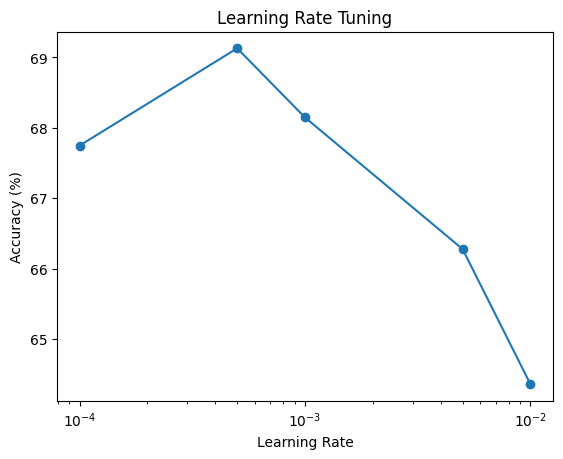

In [10]:
import os
import torch
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCDetection
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

##############################################################################
# 1) Specify the dataset location
##############################################################################
# If your folder structure is:
#   D:\saliency\VOCdevkit\VOC2012\{Annotations, ImageSets, JPEGImages, ...}
# set root to "D:\saliency" so that we have D:\saliency\VOCdevkit\VOC2012.
dataset_path = r"D:\saliency"

##############################################################################
# 2) Define the VOC classes
##############################################################################
VOC_CLASSES = [
    "__background__",  # index 0 for background
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

##############################################################################
# 3) parse_voc_annotation function
##############################################################################
def parse_voc_annotation(target):
    """
    target is a dict of the form:
      {
        'annotation': {
          'folder': 'VOC2012',
          'filename': 'xxxxxx.jpg',
          ...
          'object': [
            {
              'name': 'dog',
              'bndbox': {
                'xmin': '48',
                'ymin': '240',
                'xmax': '195',
                'ymax': '371'
              },
              ...
            },
            ...
          ]
        }
      }
    This extracts bounding boxes and labels in the format
    expected by PyTorch's detection models.
    """
    annotation = target["annotation"]
    objects = annotation.get("object", [])
    if not isinstance(objects, list):
        objects = [objects]

    boxes = []
    labels = []
    for obj in objects:
        bndbox = obj["bndbox"]
        xmin = float(bndbox["xmin"])
        ymin = float(bndbox["ymin"])
        xmax = float(bndbox["xmax"])
        ymax = float(bndbox["ymax"])
        boxes.append([xmin, ymin, xmax, ymax])

        cls_name = obj["name"]
        cls_idx = VOC_CLASSES.index(cls_name)
        labels.append(cls_idx)

    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.int64)

    return {"boxes": boxes_tensor, "labels": labels_tensor}

##############################################################################
# 4) Custom collate function for detection
##############################################################################
def detection_collate_fn(batch):
    """
    batch is a list of (image, target) pairs.
    We'll group them into (list_of_images, list_of_targets).
    """
    images = []
    targets = []
    for img, tgt in batch:
        images.append(img)
        targets.append(tgt)
    return images, targets

##############################################################################
# 5) Model creation function
##############################################################################
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

##############################################################################
# 6) Main script (use if __name__ == "__main__": to avoid Windows issues)
##############################################################################
if __name__ == "__main__":

    # Minimal transform
    transform = transforms.Compose([transforms.ToTensor()])

    # Create datasets
    train_dataset = VOCDetection(
        root=dataset_path,
        year='2012',
        image_set='train',
        transform=transform
    )
    val_dataset = VOCDetection(
        root=dataset_path,
        year='2012',
        image_set='val',
        transform=transform
    )

    # Create DataLoaders (with num_workers=0 to avoid Windows worker crashes)
    train_loader = DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=True,
        num_workers=0,
        collate_fn=detection_collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=2,
        shuffle=False,
        num_workers=0,
        collate_fn=detection_collate_fn
    )

    # Hyperparameters
    learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
    num_epochs = 5
    accuracies = []

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")
        
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        num_classes = len(VOC_CLASSES)
        model = get_model(num_classes).to(device)
        
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0001)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        
        model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
            
            for images, targets in progress_bar:
                images = [img.to(device) for img in images]
                targets_converted = [parse_voc_annotation(t) for t in targets]
                targets_converted = [{k: v.to(device) for k, v in tc.items()} for tc in targets_converted]
                
                optimizer.zero_grad()
                loss_dict = model(images, targets_converted)
                losses = sum(loss for loss in loss_dict.values())
                
                losses.backward()
                optimizer.step()
                epoch_loss += losses.item()
                progress_bar.set_postfix(loss=losses.item())
            
            lr_scheduler.step()
        
        print(f"Training complete for learning rate: {lr}")
        
        # Simple evaluation loop
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc="Evaluating"):
                images = [img.to(device) for img in images]
                outputs = model(images)
                
                for output, target in zip(outputs, targets):
                    pred_boxes = output['boxes']
                    true_boxes = parse_voc_annotation(target)['boxes'].to(device)
                    
                    for t_box in true_boxes:
                        # Example: check if predicted boxes are "close" to true boxes
                        if any(torch.allclose(t_box, p_box, atol=20.0) for p_box in pred_boxes):
                            correct += 1
                    total += len(true_boxes)
        
        accuracy = 100.0 * correct / total if total > 0 else 0
        accuracies.append(accuracy)
        print(f"Validation Accuracy for lr={lr}: {accuracy:.2f}%")

    # Plot the results
    plt.plot(learning_rates, accuracies, marker='o')
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy (%)')
    plt.title('Learning Rate Tuning')
    plt.show()
